**Comment classification using NLP**

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import RandomOverSampler


In [2]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Load dataset
df = pd.read_csv('YoutubeCommentsDataSet.csv')
df.columns = ['CONTENT', 'CLASS']
print("Sample data:\n", df.head())


Sample data:
                                              CONTENT     CLASS
0  lets not forget that apple pay in 2014 require...   neutral
1  here in nz 50 of retailers don’t even have con...  negative
2  i will forever acknowledge this channel with t...  positive
3  whenever i go to a place that doesn’t take app...  negative
4  apple pay is so convenient secure and easy to ...  positive


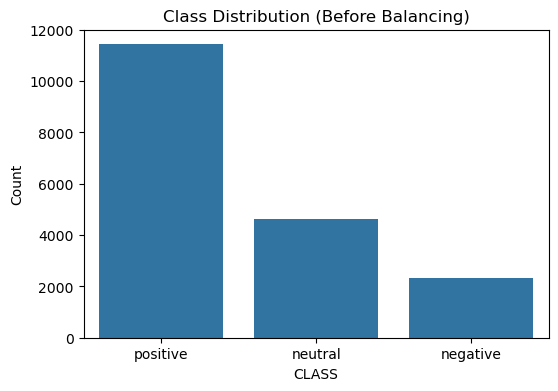

In [4]:
# Plot class distribution before balancing
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='CLASS', order=df['CLASS'].value_counts().index)
plt.title('Class Distribution (Before Balancing)')
plt.ylabel('Count')
plt.show()


In [5]:

# Text cleaning & lemmatization
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return " ".join(tokens)

df['clean_comment'] = df['CONTENT'].apply(clean_text)

In [6]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    min_df=3,
    max_df=0.9,
    max_features=20000
)
X = vectorizer.fit_transform(df['clean_comment'])
y = df['CLASS']

#  Balance classes
ros = RandomOverSampler(random_state=42)
X_bal, y_bal = ros.fit_resample(X, y)

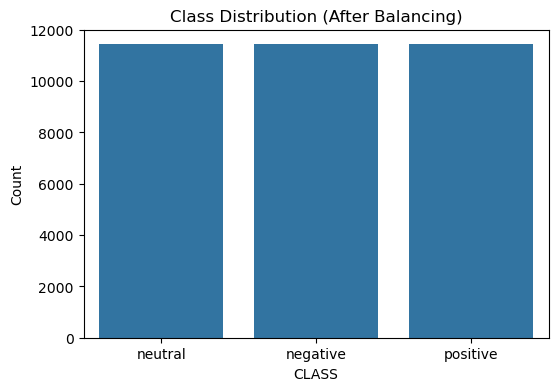

In [7]:
# Plot class distribution after balancing
plt.figure(figsize=(6, 4))
sns.countplot(x=y_bal)
plt.title('Class Distribution (After Balancing)')
plt.ylabel('Count')
plt.show()

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

In [9]:
# Tune SVM with GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100]}
grid = GridSearchCV(
    LinearSVC(class_weight='balanced', max_iter=5000),
    param_grid, cv=5, n_jobs=-1, scoring='f1_macro', return_train_score=True
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print(f"Best SVM C parameter: {grid.best_params_}")

Best SVM C parameter: {'C': 10}


In [10]:
# Evaluate
y_pred = best_model.predict(X_test)
print("\n Classification Report:\n", classification_report(y_test, y_pred))


 Classification Report:
               precision    recall  f1-score   support

    negative       0.95      1.00      0.97      2286
     neutral       0.86      0.97      0.92      2287
    positive       0.98      0.81      0.88      2287

    accuracy                           0.93      6860
   macro avg       0.93      0.93      0.92      6860
weighted avg       0.93      0.93      0.92      6860



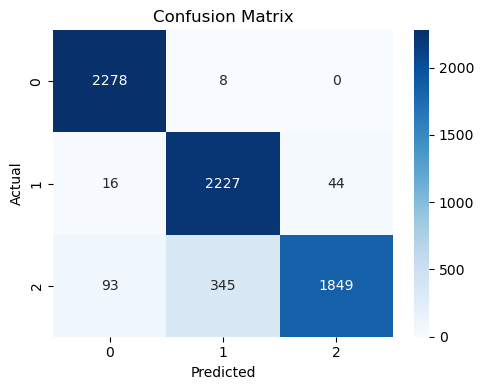

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

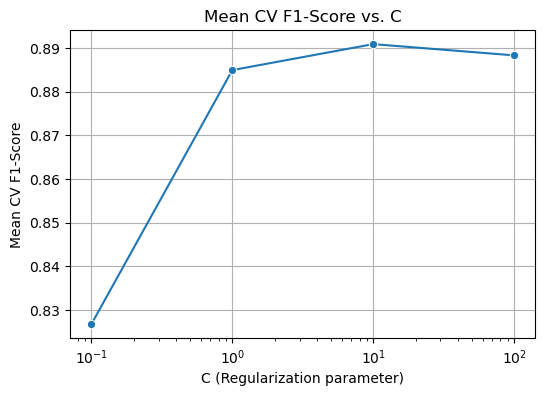

In [12]:
# Plot CV results
cv_results = pd.DataFrame(grid.cv_results_)
plt.figure(figsize=(6, 4))
sns.lineplot(data=cv_results, x='param_C', y='mean_test_score', marker='o')
plt.title('Mean CV F1-Score vs. C')
plt.xlabel('C (Regularization parameter)')
plt.ylabel('Mean CV F1-Score')
plt.xscale('log')
plt.grid(True)
plt.show()

In [13]:
# Prediction function
def predict_comment(comment):
    cleaned = clean_text(comment)
    vector = vectorizer.transform([cleaned])
    return best_model.predict(vector)[0]

In [17]:
# Test predictions
print("\nExample Prediction 1:", predict_comment("forever acknowledge channel help lessons ideas explanations quite helpful"))
print("Example Prediction 2:", predict_comment("This was the worst video ever."))



Example Prediction 1: positive
Example Prediction 2: negative
